<b>Siamese Network</b>

In [1]:
import numpy as np
import torch

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
# Dataset

from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
import torch.utils as utils
from torch.utils.data import Dataset

class SiameseDataset(Dataset):
  def __init__(self, root, train, download, transform):
    self.data = dataset_train = datasets.MNIST(
                                  root='./data', 
                                  train=train, 
                                  download=download, 
                                  transform=transform)
    self.img = self.data.data
    self.label = self.data.targets
  def __getitem__(self, idx):
    img1   = self.img[idx]
    label1 = self.label[idx]
    target = np.random.randint(0, 2)
    while True:
      rand = np.random.randint(self.img.shape[0])
      label2 = self.label[rand]
      if (label1 == label2) == (target > 0):
        img2 = self.img[rand]
        break
    return img1, img2, target
  def __len__(self):
    return len(self.data)

transform = transforms.Compose([
    transforms.ToTensor()])

batch_size = 1000

dataset_train = SiameseDataset(
    './data', 
    train=True, 
    download=True, 
    transform=transform)

dataset_test  = SiameseDataset(
    './data', 
    train=False, 
    download=True, 
    transform=transform)

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)
dataloader_test  = utils.data.DataLoader(dataset_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

In [3]:
# Network

import torch.nn as nn
import torch.nn.functional as F

class SiameseNet(nn.Module):
  def __init__(self):
    super(SiameseNet, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    self.fc = nn.Sequential(
        nn.Linear(32 * 4 * 4, 256),
        nn.ReLU(),
        nn.Linear(256, 100),
        nn.ReLU(),
        nn.Linear(100, 2)
    )

  def forward(self, xa1, xb1):
    xa2 = self.conv(xa1)
    xa3 = xa2.view(xa2.size()[0], -1)
    ya  = self.fc(xa3)
    xb2 = self.conv(xb1)
    xb3 = xb2.view(xb2.size()[0], -1)
    yb  = self.fc(xb3)
    return ya, yb

  def forward_plot(self, x1):
    x2 = self.conv(x1)
    x3 = x2.view(x2.size()[0], -1)
    y  = self.fc(x3)
    return y

In [4]:
# Training

from torch import optim
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
  def __init__(self, margin):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
    self.eps = 1e-9

  def forward(self, ya, yb, target):
    distances = (yb - ya).pow(2).sum(1)
    losses = 0.5 * (target.float() * distances +
                (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
    return losses.sum()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = ContrastiveLoss(1.0)

for i in range(20):
  print(f"EPOCH: {i+1}")

  ### Train ###
  model.train()
  for xa, xb, target in dataloader_train:
    xa = xa.to(device).unsqueeze(1).float()
    xb = xb.to(device).unsqueeze(1).float()
    target = target.to(device)
    model.zero_grad()
    ya, yb = model(xa, xb)
    loss = criterion(ya, yb, target)/batch_size
    loss.backward()
    optimizer.step()

  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for xa, xb, target in dataloader_train:
    xa = xa.to(device).unsqueeze(1).float()
    xb = xb.to(device).unsqueeze(1).float()
    target = target.to(device)
    ya, yb = model(xa, xb)
    loss = criterion(ya, yb, target)/batch_size
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  train loss: {sum_loss/sum_iter}")

  ### Test ###
  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for xa, xb, target in dataloader_test:
    xa = xa.to(device).unsqueeze(1).float()
    xb = xb.to(device).unsqueeze(1).float()
    target = target.to(device)
    ya, yb = model(xa, xb)
    loss = criterion(ya, yb, target)/batch_size
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  test  loss: {sum_loss/sum_iter}")

EPOCH: 1
  train loss: 0.06230924924214681
  test  loss: 0.0611865971237421
EPOCH: 2
  train loss: 0.05192843240996202
  test  loss: 0.05260422229766846
EPOCH: 3
  train loss: 0.04458270433048407
  test  loss: 0.044208836555480954
EPOCH: 4
  train loss: 0.03921012779076894
  test  loss: 0.04013759940862656
EPOCH: 5
  train loss: 0.033483336493372914
  test  loss: 0.03484571762382984
EPOCH: 6
  train loss: 0.02989148013293743
  test  loss: 0.03180018253624439
EPOCH: 7
  train loss: 0.026276369827489057
  test  loss: 0.029071053862571715
EPOCH: 8
  train loss: 0.0233626379010578
  test  loss: 0.02463732585310936
EPOCH: 9
  train loss: 0.020890095022817454
  test  loss: 0.022884294390678406
EPOCH: 10
  train loss: 0.018635682513316473
  test  loss: 0.021054600924253465
EPOCH: 11
  train loss: 0.016789140924811364
  test  loss: 0.02004069071263075
EPOCH: 12
  train loss: 0.015034638671204447
  test  loss: 0.018731730058789253
EPOCH: 13
  train loss: 0.01321206457602481
  test  loss: 0.0161

In [5]:
# Plot

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

dataset_plot_train = datasets.MNIST(
    './data', 
    train=True, 
    download=True, 
    transform=transform)
dataset_plot_test  = datasets.MNIST(
    './data', 
    train=False, 
    download=True, 
    transform=transform)

dataloader_plot_train = utils.data.DataLoader(dataset_plot_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)
dataloader_plot_test  = utils.data.DataLoader(dataset_plot_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)


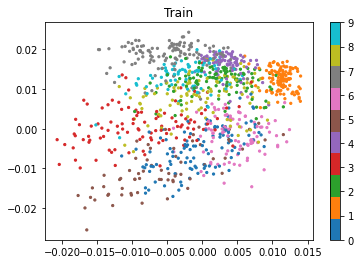

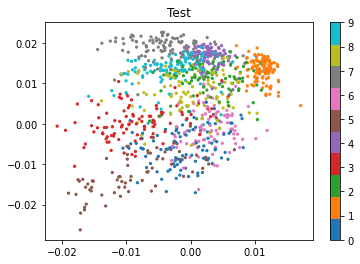

In [6]:
### Train ###
x, t = iter(dataloader_plot_train).next()
x = x.to(device)
y = model.forward_plot(x)
y = y.cpu().detach().numpy()

plt.scatter(y[:,0], y[:,1], c=t, s=5, cmap=cm.tab10)
plt.title("Train")
plt.colorbar()
plt.show()

### Test ###
x, t = iter(dataloader_plot_test).next()
x = x.to(device)
y = model.forward_plot(x)
y = y.cpu().detach().numpy()

plt.scatter(y[:,0], y[:,1], c=t, s=5, cmap=cm.tab10)
plt.title("Test")
plt.colorbar()
plt.show()

参考<br>
https://github.com/adambielski/siamese-triplet